In [1]:
# Should be done in previous part...
%cd {pwd}/../

from app.main import load_dataset, train_test_split, RANDOM_SEED
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

dataset, labels = load_dataset("./dataset/train")
img_train, img_test, label_train, label_test = train_test_split(
        dataset, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

[Errno 2] No such file or directory: '{pwd}/../'
/home/bouteille/Documents/iml-project/notebooks


ModuleNotFoundError: No module named 'utils'

In [166]:
from sklearn.cluster import KMeans

In [167]:
def create_mask(img):
    selector = (img[...,0] == 255) & (img[...,1] == 255) & (img[...,2] == 255)
    return ~selector

mask_train = [create_mask(img) for img in img_train]

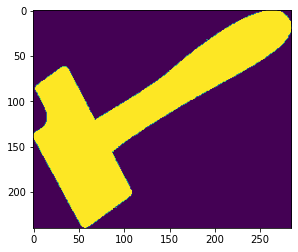

In [168]:
# Display example mask
plt.imshow(mask_train[0])

In [169]:
samples = []
for (i, img) in enumerate(img_train):
    img_masked = img[mask_train[i]]
    indices = np.random.choice(img_masked.shape[0], 50, replace=False)
    sample = img_masked[indices]

    samples.append(sample)

super_sample = np.vstack(samples)

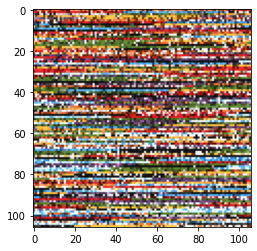

In [170]:
# Display super sample
side = int(sqrt(float(super_sample.shape[0])))
plt.imshow(super_sample[:(side * side)].reshape((side, side, 3)))

In [171]:
# Count unique colors
np.unique(super_sample, axis=0).shape[0]

8731

In [180]:
kmean_color = KMeans(n_clusters=24, random_state=RANDOM_SEED)
kmean_color.fit(super_sample)

KMeans(n_clusters=24, random_state=40)

<BarContainer object of 24 artists>

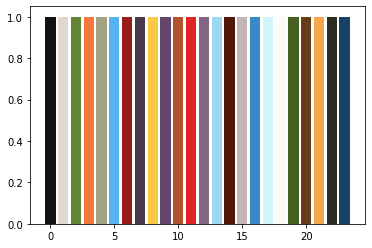

In [181]:
color_lut = np.uint8(kmean_color.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.ones(len(color_lut)), 
         color=color_lut/255)

In [182]:
label_maps = []
for img, mask in zip(img_train, mask_train):
    lm = kmean_color.predict(img[mask])
    label_maps.append(lm)

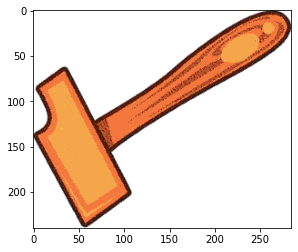

In [183]:
recolored_img = np.ones(img_train[0].shape, dtype=np.uint8) * 255
recolored_img[mask_train[0]] = color_lut[label_maps[0]]
plt.imshow(recolored_img)

In [186]:
# Extract histogram (use minlength to ensure homogeneous dimensionality)
histograms = np.array([np.bincount(lm, minlength=len(
        kmean_color.cluster_centers_)) / len(lm) for lm in label_maps], dtype=np.float64)

<BarContainer object of 24 artists>

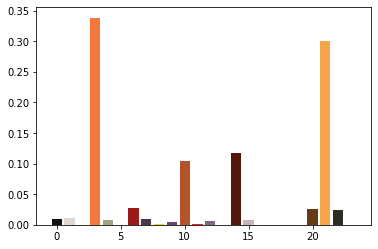

In [191]:
plt.bar(np.arange(len(color_lut)), 
         histograms[0], 
         color=color_lut/255)

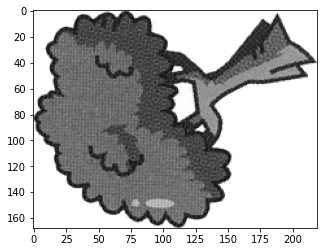

In [263]:
import cv2

gray_img = cv2.cvtColor(img_train[5], cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')


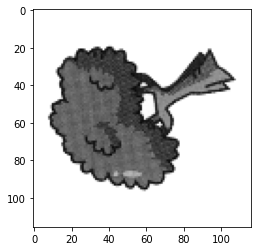

In [265]:
height, width = gray_img.shape
if height > width:
    square_img = cv2.copyMakeBorder(gray_img, 0, 0, (height - width) // 2, (height - width) // 2, cv2.BORDER_CONSTANT, value=255)
elif width > height:
    square_img = cv2.copyMakeBorder(gray_img, (width - height) // 2, (width - height) // 2, 0, 0,  cv2.BORDER_CONSTANT, value=255)

resized_img = cv2.resize(square_img, (100, 100))
padded_img = cv2.copyMakeBorder(resized_img, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)

plt.imshow(padded_img, cmap='gray')

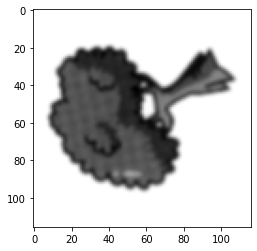

In [266]:
blurred_img = cv2.GaussianBlur(padded_img, (5, 5), 0)
plt.imshow(blurred_img, cmap='gray')

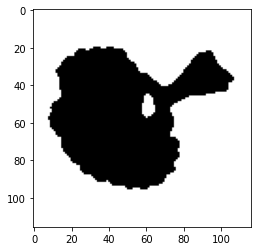

In [267]:
_, binary_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary_img, cmap='gray')

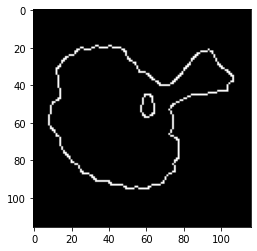

In [268]:
canny_img = cv2.Canny(binary_img, 100, 200)
plt.imshow(canny_img, cmap='gray')

In [269]:
moments = cv2.moments(canny_img)
hu_moments = cv2.HuMoments(moments).flatten()
hu_moments

array([ 1.46628235e-02,  1.25688312e-05,  4.15935490e-07,  4.47810598e-08,
       -5.52307541e-15,  1.58158577e-10,  2.61672062e-15])

<BarContainer object of 7 artists>

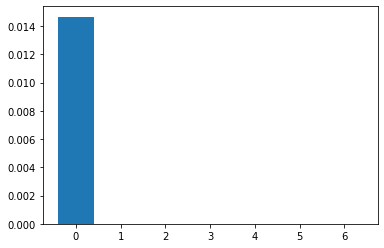

In [270]:
plt.bar(np.arange(len(hu_moments)), hu_moments)

<BarContainer object of 7 artists>

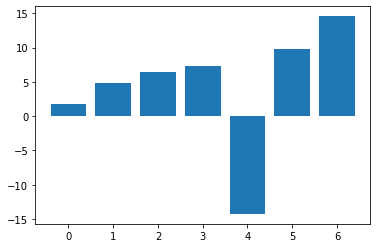

In [271]:
hu_moments_log = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
plt.bar(np.arange(len(hu_moments_log)), hu_moments_log)